In [1]:
!pip install fastaudio
!pip install fastai==2.5.2
!pip install matplotlib==3.2.2
!pip install scikit-learn==1.0.2

  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 194 kB 1.3 MB/s            
     |████████████████████████████████| 1.9 MB 8.7 MB/s            
     |████████████████████████████████| 183 kB 33.3 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 53 kB 1.8 MB/s             
     |████████████████████████████████| 804.1 MB 1.3 kB/s             
  Created wheel for librosa: filename=librosa-0.8.0-py3-none-any.whl size=201395 sha256=564cefcec5466320b034d156d77a8aa82838e4ace51ee80edb41cca284b1e85e
  Stored in directory: /root/.cache/pip/wheels/de/1e/aa/d91797ae7e1ce11853ee100bee9d1781ae9d750e7458c95afb
  Created wheel for colorednoise: filename=colorednoise-1.1.1-py3-none-any.whl size=3982 sha256=60917a8f6980e5e48ca3eb94161020b9ae545c37491aaf7105f13a3571b8b402
  Stored in directory: /root/.cache/pip/wheels/1a/ca/93/dfd64286aef6fc206b727bd4cf2d5c17efe34d62b918c8f4a7
Successfully built librosa colorednoise
  Atte

In [1]:
from fastai.vision.all import *
from fastaudio.core.all import *
from fastaudio.augment.all import *
from fastaudio.ci import skip_if_ci

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import*
from imblearn.metrics import specificity_score

import numpy as np
import pandas as pd

/opt/conda/lib/python3.7/site-packages/torchaudio/backend/utils.py:47: UserWarning: "torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE" flag is deprecated and will be removed in 0.9.0. Please remove the use of flag.
  '"torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE" flag is deprecated and will be removed in 0.9.0. '


# Preprocessing

In [2]:
CVD_loc = "../input/coughvid-wav/"
path = '../input/coughvid-wav/public_dataset/'

In [3]:
cvd_df = pd.read_csv(CVD_loc+"public_dataset/"+"metadata_compiled.csv")
cvd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27550 entries, 0 to 27549
Data columns (total 51 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   uuid                   27550 non-null  object 
 1   datetime               27550 non-null  object 
 2   cough_detected         27550 non-null  float64
 3   SNR                    27550 non-null  float64
 4   latitude               16084 non-null  float64
 5   longitude              16084 non-null  float64
 6   age                    15218 non-null  float64
 7   gender                 16224 non-null  object 
 8   respiratory_condition  16224 non-null  object 
 9   fever_muscle_pain      16224 non-null  object 
 10  status                 16224 non-null  object 
 11  quality_1              820 non-null    object 
 12  cough_type_1           802 non-null    object 
 13  dyspnea_1              820 non-null    object 
 14  wheezing_1             820 non-null    object 
 15  st

In [4]:
# remove unnecessary columns

cvd_df = cvd_df.drop(columns=['datetime', 'latitude', 'longitude', 'age', 'gender', 'fever_muscle_pain',
                          'cough_type_1','dyspnea_1','wheezing_1','stridor_1','choking_1','congestion_1','nothing_1',
                          'cough_type_2','dyspnea_2','wheezing_2','stridor_2','choking_2','congestion_2','nothing_2',
                          'cough_type_3','dyspnea_3','wheezing_3','stridor_3','choking_3','congestion_3','nothing_3',
                          'cough_type_4','dyspnea_4','wheezing_4','stridor_4','choking_4','congestion_4','nothing_4'
                         ])

In [5]:
# 'cough_detected' == Probability that the recording contains cough sounds, according to their automatic detection algorithm
# also expert annotation has 'quality' of the recorded cough sound

cvd_df = cvd_df[(cvd_df['cough_detected'] > 0.8) 
                & (cvd_df['quality_1'] != 'no_cough')
                & (cvd_df['quality_2'] != 'no_cough')
                & (cvd_df['quality_3'] != 'no_cough')
                & (cvd_df['quality_4'] != 'no_cough') 
                & (cvd_df['quality_1'] != 'poor')
                & (cvd_df['quality_2'] != 'poor')
                & (cvd_df['quality_3'] != 'poor')
                & (cvd_df['quality_4'] != 'poor')
               ]

cvd_df.info()
cvd_df[:5]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14844 entries, 1 to 27549
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   uuid                   14844 non-null  object 
 1   cough_detected         14844 non-null  float64
 2   SNR                    14844 non-null  float64
 3   respiratory_condition  10579 non-null  object 
 4   status                 10579 non-null  object 
 5   quality_1              638 non-null    object 
 6   diagnosis_1            638 non-null    object 
 7   severity_1             638 non-null    object 
 8   quality_2              686 non-null    object 
 9   diagnosis_2            686 non-null    object 
 10  severity_2             686 non-null    object 
 11  quality_3              747 non-null    object 
 12  diagnosis_3            747 non-null    object 
 13  severity_3             747 non-null    object 
 14  quality_4              743 non-null    object 
 15  di

uuid  cough_detected        SNR  \
1   00039425-7f3a-42aa-ac13-834aaa2b6b92          0.9609  16.151433   
3   0009eb28-d8be-4dc1-92bb-907e53bc5c7a          0.9301  20.146058   
5   001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f          0.9968  13.146502   
10  0028b68c-aca4-4f4f-bb1d-cb4ed5bbd952          0.8937  13.477551   
11  00291cce-36a0-4a29-9e2d-c1d96ca17242          0.9883  14.603851   

   respiratory_condition   status quality_1 diagnosis_1 severity_1 quality_2  \
1                  False  healthy       NaN         NaN        NaN       NaN   
3                   True  healthy       NaN         NaN        NaN       NaN   
5                  False  healthy       NaN         NaN        NaN       NaN   
10                 False  healthy       NaN         NaN        NaN       NaN   
11                 False  healthy       NaN         NaN        NaN       NaN   

   diagnosis_2 severity_2 quality_3 diagnosis_3 severity_3 quality_4  \
1          NaN        NaN       NaN         NaN        NaN       NaN   
3          NaN        NaN       NaN         NaN        NaN       NaN   
5          NaN        NaN       NaN         NaN        NaN       NaN   
10         NaN        NaN       NaN         NaN        NaN       NaN   
11         NaN        NaN       NaN         NaN        NaN       NaN   

   diagnosis_4 severity_4  
1          NaN        NaN  
3          NaN        NaN  
5          NaN        NaN  
10         NaN        NaN  
11         NaN        NaN

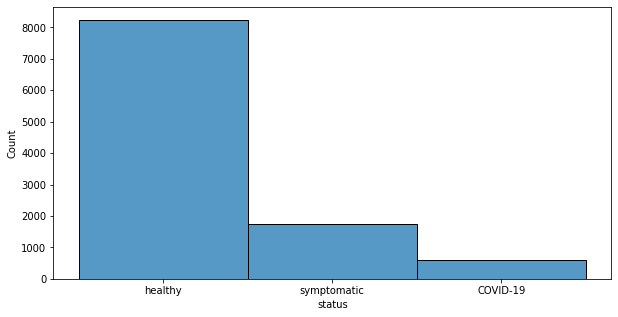

In [6]:
import seaborn as sns
plt.figure(figsize=(10,5))
sns.histplot(cvd_df['status'])

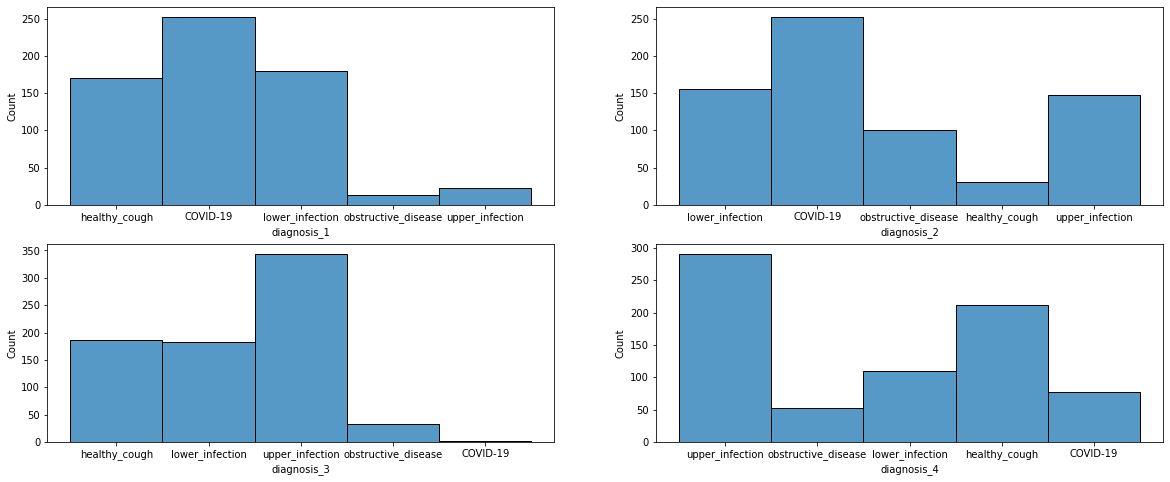

In [7]:
plt.figure(figsize=(20,8))

plt.subplot(2, 2, 1)
sns.histplot(cvd_df['diagnosis_1'])
plt.subplot(2, 2, 2)
sns.histplot(cvd_df['diagnosis_2'])
plt.subplot(2, 2, 3)
sns.histplot(cvd_df['diagnosis_3'])
plt.subplot(2, 2, 4)
sns.histplot(cvd_df['diagnosis_4'])

In [8]:
# The patient's "status" is 'COVID-19' 

cvd_covid = cvd_df[(cvd_df.status == 'COVID-19')]

#cvd_covid.to_csv('cvd_covid.csv')

print('SAMPLES: -->',len(cvd_covid))
cvd_covid.info()
cvd_covid[:3]

SAMPLES: --> 596
<class 'pandas.core.frame.DataFrame'>
Int64Index: 596 entries, 140 to 27503
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   uuid                   596 non-null    object 
 1   cough_detected         596 non-null    float64
 2   SNR                    596 non-null    float64
 3   respiratory_condition  596 non-null    object 
 4   status                 596 non-null    object 
 5   quality_1              145 non-null    object 
 6   diagnosis_1            145 non-null    object 
 7   severity_1             145 non-null    object 
 8   quality_2              154 non-null    object 
 9   diagnosis_2            154 non-null    object 
 10  severity_2             154 non-null    object 
 11  quality_3              176 non-null    object 
 12  diagnosis_3            176 non-null    object 
 13  severity_3             176 non-null    object 
 14  quality_4              187 non-null  

uuid  cough_detected        SNR  \
140  015576c8-2b03-4dcb-b251-78a984fe86fe             1.0  12.265701   
155  0177b817-0ba3-498a-bc05-48bc66cc91b8             1.0  20.441756   
158  01820f7c-b953-4faf-aa13-978cfda6b08e             1.0   9.280698   

    respiratory_condition    status quality_1 diagnosis_1 severity_1  \
140                 False  COVID-19       NaN         NaN        NaN   
155                 False  COVID-19       NaN         NaN        NaN   
158                 False  COVID-19       NaN         NaN        NaN   

    quality_2          diagnosis_2 severity_2 quality_3 diagnosis_3  \
140       NaN                  NaN        NaN       NaN         NaN   
155        ok  obstructive_disease       mild       NaN         NaN   
158       NaN                  NaN        NaN       NaN         NaN   

    severity_3 quality_4          diagnosis_4 severity_4  
140        NaN      good  obstructive_disease       mild  
155        NaN       NaN                  NaN        NaN  
158        NaN      good  obstructive_disease     severe

In [9]:
# The patient "status" is 'healthy'
# to balance the ratio with covid positive samples, added some extra condition like ->
# patinet has 'no' "respiratory_condition" AND
# expert "diagnosis" is not 'upper_infection, lower_infection, obstructive_disease, COVID-19 and
# selected 1788 (3x times covid positive samples) after sorting the dataframe by 'cough_detected', 'SNR' values
 
cvd_healthy = cvd_df[(cvd_df['status'] == 'healthy') 
                     &(cvd_df['respiratory_condition'] == False) 
                     &(cvd_df['diagnosis_1'] != 'upper_infection')
                     &(cvd_df['diagnosis_2'] != 'upper_infection')
                     &(cvd_df['diagnosis_3'] != 'upper_infection')
                     &(cvd_df['diagnosis_4'] != 'upper_infection') 
                     &(cvd_df['diagnosis_1'] != 'lower_infection')
                     &(cvd_df['diagnosis_2'] != 'lower_infection')
                     &(cvd_df['diagnosis_3'] != 'lower_infection')
                     &(cvd_df['diagnosis_4'] != 'lower_infection')
                     &(cvd_df['diagnosis_1'] != 'obstructive_disease')
                     &(cvd_df['diagnosis_2'] != 'obstructive_disease')
                     &(cvd_df['diagnosis_3'] != 'obstructive_disease')
                     &(cvd_df['diagnosis_4'] != 'obstructive_disease')
                     &(cvd_df['diagnosis_1'] != 'COVID-19')
                     &(cvd_df['diagnosis_2'] != 'COVID-19')
                     &(cvd_df['diagnosis_3'] != 'COVID-19')
                     &(cvd_df['diagnosis_4'] != 'COVID-19')
                    ]

cvd_healthy = cvd_healthy.sort_values(by=['cough_detected', 'SNR'], ascending=False)
cvd_healthy = cvd_healthy[:(596*3)]

#cvd_healthy.to_csv('cvd_healthy.csv')

print('SAMPLES: -->',len(cvd_healthy))
cvd_healthy.info()
cvd_healthy[:3]

SAMPLES: --> 1788
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1788 entries, 6591 to 13242
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   uuid                   1788 non-null   object 
 1   cough_detected         1788 non-null   float64
 2   SNR                    1788 non-null   float64
 3   respiratory_condition  1788 non-null   object 
 4   status                 1788 non-null   object 
 5   quality_1              38 non-null     object 
 6   diagnosis_1            38 non-null     object 
 7   severity_1             38 non-null     object 
 8   quality_2              9 non-null      object 
 9   diagnosis_2            9 non-null      object 
 10  severity_2             9 non-null      object 
 11  quality_3              30 non-null     object 
 12  diagnosis_3            30 non-null     object 
 13  severity_3             30 non-null     object 
 14  quality_4              70 non-null

uuid  cough_detected        SNR  \
6591   3d8a71a7-e94f-425c-8b92-09aceddcd063             1.0  78.847184   
2434   16af8331-f890-4f2e-bf49-2b42985d379e             1.0  76.186442   
10806  647da923-9dfe-4527-9ec6-473b8fb791ca             1.0  75.226517   

      respiratory_condition   status quality_1 diagnosis_1 severity_1  \
6591                  False  healthy       NaN         NaN        NaN   
2434                  False  healthy       NaN         NaN        NaN   
10806                 False  healthy       NaN         NaN        NaN   

      quality_2 diagnosis_2 severity_2 quality_3 diagnosis_3 severity_3  \
6591        NaN         NaN        NaN       NaN         NaN        NaN   
2434        NaN         NaN        NaN       NaN         NaN        NaN   
10806       NaN         NaN        NaN       NaN         NaN        NaN   

      quality_4    diagnosis_4   severity_4  
6591       good  healthy_cough  pseudocough  
2434       good  healthy_cough  pseudocough  
10806      good  healthy_cough  pseudocough

In [10]:
# loads all file paths from location

cvd_files = get_files(
  path = path,
  extensions = '.wav',
  recurse = True
)

print(len(cvd_files))
cvd_files[:3]

27550


(#3) [Path('../input/coughvid-wav/public_dataset/7444620d-bf48-451b-8e48-7c632d8f5a1c.wav'),Path('../input/coughvid-wav/public_dataset/4344101d-3fc1-47fd-be0d-c8d4b4caa940.wav'),Path('../input/coughvid-wav/public_dataset/bb0c6cd9-6465-47ad-be51-7189156d5f2e.wav')]

In [11]:
# method to get file paths

def getit(id):
    for i in cvd_files:
        folders = str(i).split("/")[-1].split('.wav')
        #print(folders)
        if folders[0] == id:
            #print(str(i).split('public_dataset/')[-1])
            return str(i).split('public_dataset/')[-1]

In [12]:
file_names = []
labels = []

for i in cvd_covid.uuid.values:
    file_names.append(getit(i))
    labels.append('COVID POSITIVE')

for i in cvd_healthy.uuid.values:
    file_names.append(getit(i))
    labels.append('COVID NEGATIVE')
    
print(file_names[:3])
print(labels[:3])

Counter(labels)

['015576c8-2b03-4dcb-b251-78a984fe86fe.wav', '0177b817-0ba3-498a-bc05-48bc66cc91b8.wav', '01820f7c-b953-4faf-aa13-978cfda6b08e.wav']
['COVID POSITIVE', 'COVID POSITIVE', 'COVID POSITIVE']


Counter({'COVID POSITIVE': 596, 'COVID NEGATIVE': 1788})

In [13]:
# dataframe for dataloader

df = pd.DataFrame({'filename' : file_names, 'category': labels})
three_df = df.copy()
three_df

filename        category
0     015576c8-2b03-4dcb-b251-78a984fe86fe.wav  COVID POSITIVE
1     0177b817-0ba3-498a-bc05-48bc66cc91b8.wav  COVID POSITIVE
2     01820f7c-b953-4faf-aa13-978cfda6b08e.wav  COVID POSITIVE
3     01bf156f-a8ff-48f6-9335-8a1f5bb4c1b7.wav  COVID POSITIVE
4     02aa80ef-a83b-477f-b01d-575651364b22.wav  COVID POSITIVE
...                                        ...             ...
2379  fbcd0f5a-5778-43a2-ac82-52e2077f5e9b.wav  COVID NEGATIVE
2380  81a9a512-b01f-4115-bf8c-f60728fdf0dc.wav  COVID NEGATIVE
2381  43e48031-e0db-441d-9b18-dc882cc99867.wav  COVID NEGATIVE
2382  f1b4540e-c434-42dd-bce7-46ba54240c39.wav  COVID NEGATIVE
2383  7ac68b6e-ea41-4eb0-9eda-7b09169dce8f.wav  COVID NEGATIVE

[2384 rows x 2 columns]

In [14]:
# # check audio files samplerate

# sr_list = []

# for i in three_df.filename.values:
#     sr_list.append(librosa.get_samplerate(path+i))
    
# sr_list = np.array(sr_list)

# values, counts = np.unique(sr_list, return_counts=True)
# print(values, counts)

# #output [48000] [2384]

# # check duration of each files

# dur_list = []
# failed_list = []
# for i in three_df.filename.values:
#     try:
#         y, sr = librosa.load(path+i)
#         dur_list.append(librosa.get_duration(y=y, sr=sr))
#     except:
#         failed_list.append(i)
#         pass
    
# dur_list = np.array(dur_list)

# print(np.mean(dur_list))
# print(np.average(dur_list))

# #output
# #8.434474425116804
# #8.434474425116804

# # files failed to load
# print(failed_list[:3])
# len(failed_list)

# # remove corrupted files
# for i in failed_list:
#     print(i)
#     three_df.drop(three_df[three_df.filename == i].index, inplace=True)
# three_df

COVID NEGATIVE    1788
COVID POSITIVE     596
Name: category, dtype: int64

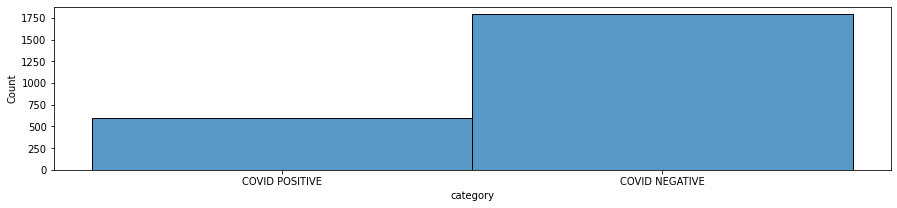

In [15]:
# check class distribution
plt.figure(figsize=(15,3))
sns.histplot(three_df['category'])

three_df['category'].value_counts()

In [16]:
three_df.to_csv('coughvid_df_2class.csv', index=False) 

# MFCC

In [92]:
# resize audio to a uniform length and create mel-spectrogram from audio
crop8s = ResizeSignal(duration=8000)
aud2mfcc = AudioToMFCC(sample_rate=22050, n_mfcc=70, log_mels=False, 
                       melkwargs={'n_fft':2048, 'hop_length':256,'n_mels':128})

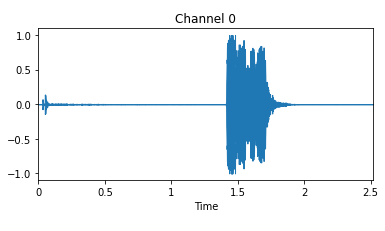

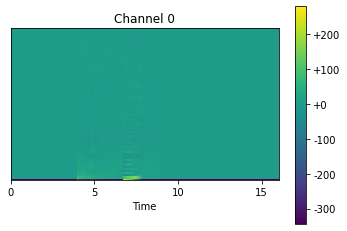

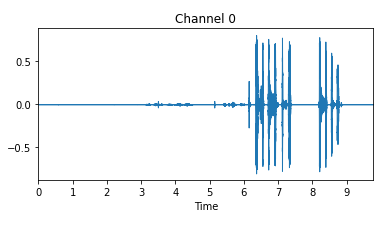

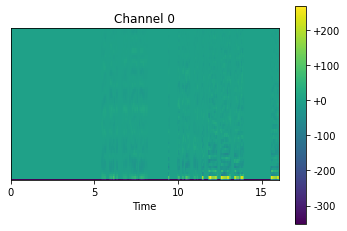

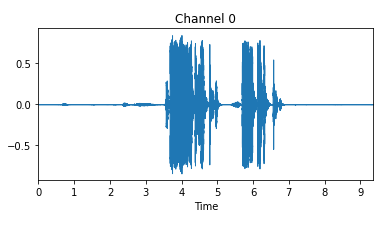

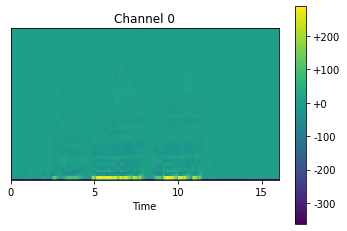

In [93]:
# check transformations
pipe = Pipeline([AudioTensor.create, crop8s, aud2mfcc])

for fn in three_df.filename.values[42:45]:
      audio = AudioTensor.create(path+fn)
      audio.show()
      pipe(path+fn).show()

## Dataloader

In [94]:
three_df, three_df_test = train_test_split(three_df, test_size=0.10, random_state=29, stratify=three_df.category.values)

In [95]:
print(three_df.category.value_counts())
print(three_df_test.category.value_counts())

COVID NEGATIVE    1303
COVID POSITIVE     434
Name: category, dtype: int64
COVID NEGATIVE    145
COVID POSITIVE     48
Name: category, dtype: int64


Setting-up type transforms pipelines
431   bed17bfe-d49d-44a1-a3d1-40ae3249ec52.wav  COVID POSITIVE
176   4eab6d7e-32c1-4a7f-be8c-b1cbcffe2420.wav  COVID POSITIVE
5     031fd54a-87b5-4223-9af6-60985127fb7a.wav  COVID POSITIVE
1477  b09f5d4b-d639-4cf2-b842-87509345f116.wav  COVID NEGATIVE
1956  77800031-0bbe-40e2-add3-19ea8b2ac6ff.wav  COVID NEGATIVE
...                                        ...             ...
1339  6eff8ab6-76dc-4925-8102-12508971030c.wav  COVID NEGATIVE
1757  a1f03523-0d97-4046-a286-c301996b9e8d.wav  COVID NEGATIVE
1171  0ded71d7-8cd0-4a7a-9ec5-00316f088be5.wav  COVID NEGATIVE
46    1614e597-81d6-4db4-9bed-43eff6c8effc.wav  COVID POSITIVE
2149  0f88ff35-3f66-42a2-b921-25e37db9011e.wav  COVID NEGATIVE

[1737 rows x 2 columns]
Found 1737 items
2 datasets of sizes 1563,174
Setting up Pipeline: ColReader -- {'cols': 'filename', 'pref': '../input/coughvid-wav/public_dataset/', 'suff': '', 'label_delim': None} -> partial
Setting up Pipeline: ColReader -- {'cols': 'categor

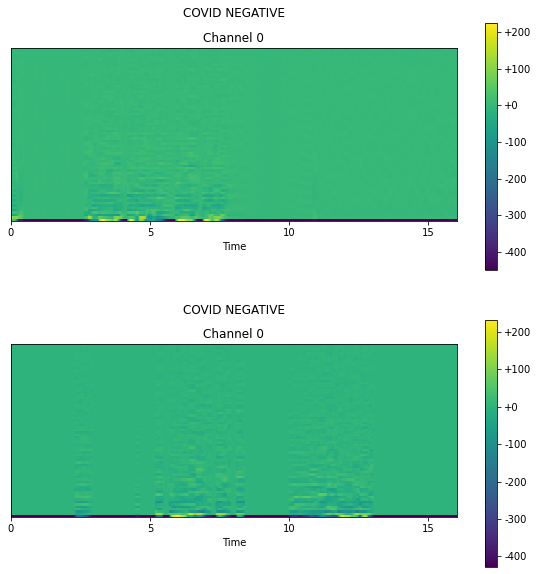

In [96]:
item_tfms = [crop8s, aud2mfcc]

auds = DataBlock(blocks = (AudioBlock, CategoryBlock),  
                 get_x = ColReader("filename", pref= path),
                 splitter = TrainTestSplitter(test_size=0.10, random_state=29, 
                                              stratify=three_df.category.values),
                 item_tfms = item_tfms,
                 get_y = ColReader("category"))


auds.summary(three_df, show_batch=True, figsize=(10, 10))

## Check data distribution

In [97]:
dls = auds.dataloaders(three_df, bs=32)

for i in range(10):
    x,y = dls.one_batch()
    print(np.unique(y.cpu(), return_counts=True))

(array([0, 1]), array([21, 11]))
(array([0, 1]), array([25,  7]))
(array([0, 1]), array([22, 10]))
(array([0, 1]), array([27,  5]))
(array([0, 1]), array([22, 10]))
(array([0, 1]), array([21, 11]))
(array([0, 1]), array([27,  5]))
(array([0, 1]), array([22, 10]))
(array([0, 1]), array([28,  4]))
(array([0, 1]), array([21, 11]))


In [98]:
test_dl = dls.test_dl(three_df_test, with_labels=True)

In [99]:
print(dls.train.items.category.value_counts())
print(dls.valid.items.category.value_counts())
print(test_dl.items.category.value_counts())

COVID NEGATIVE    1172
COVID POSITIVE     391
Name: category, dtype: int64
COVID NEGATIVE    131
COVID POSITIVE     43
Name: category, dtype: int64
COVID NEGATIVE    145
COVID POSITIVE     48
Name: category, dtype: int64


# Models: Fine-tuning

### ResNet-18

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Better model found at epoch 0 with accuracy value: 0.6580311059951782.


Better model found at epoch 0 with accuracy value: 0.6787564754486084.
Better model found at epoch 1 with accuracy value: 0.7098445892333984.
Better model found at epoch 2 with accuracy value: 0.7305699586868286.
Better model found at epoch 3 with accuracy value: 0.7357512712478638.
Better model found at epoch 4 with accuracy value: 0.772020697593689.
No improvement since epoch 4: early stopping


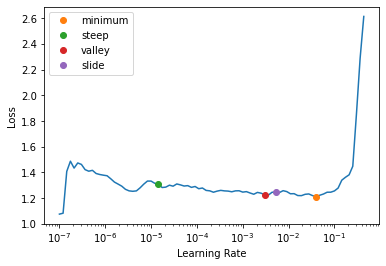

In [31]:
# resnet 18 model
learn = cnn_learner(dls, resnet18, # <- model
                    n_in=1,  # <- This is the only audio specific modification here
                    metrics=[accuracy, RocAucBinary(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True), EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Run 
learn.fine_tune(50, lrs.valley)

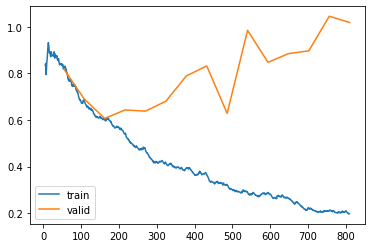

In [32]:
learn.recorder.plot_loss()

0.7441860465116279 0.5810904071773637 0.5816972655559093 0.5768921095008052 0.5768921095008052 0.6316981875492513
^^    accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.78      0.91      0.84       161
           1       0.48      0.24      0.32        54

    accuracy                           0.74       215
   macro avg       0.63      0.58      0.58       215
weighted avg       0.71      0.74      0.71       215



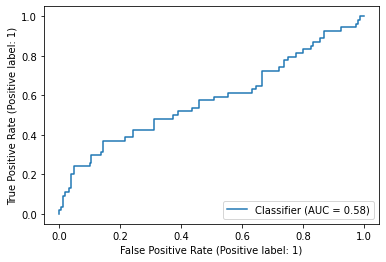

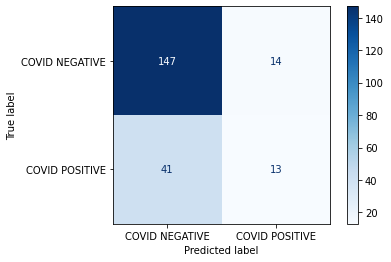

In [33]:
xx = learn.load('./model')

pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)

acc = accuracy_score(actual_classes, pred_classes)
rocauc = roc_auc_score(actual_classes, pred_probas[:, 1], average='macro')
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^    accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))       
RocCurveDisplay.from_predictions(actual_classes, pred_probas[:, 1])
plt.show()

ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab,cmap=plt.cm.Blues)
plt.show()

### ResNet-34

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Better model found at epoch 0 with accuracy value: 0.6787564754486084.


Better model found at epoch 0 with accuracy value: 0.7616580128669739.
Better model found at epoch 5 with accuracy value: 0.7772020697593689.
No improvement since epoch 5: early stopping


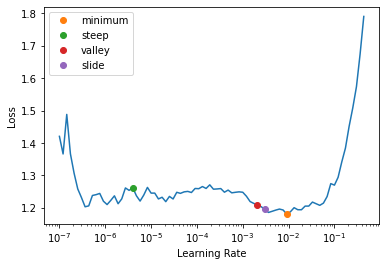

In [34]:
learn = cnn_learner(dls, resnet34, # <- model
                    n_in=1,  # <- This is the only audio specific modification here
                    metrics=[accuracy, RocAucBinary(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True), EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Run 
learn.fine_tune(50, lrs.valley)

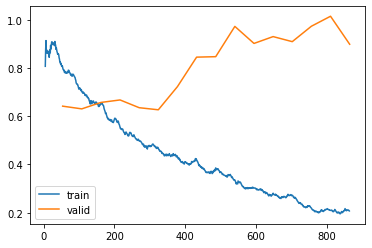

In [35]:
learn.recorder.plot_loss()

0.7488372093023256 0.6545893719806763 0.6142344497607655 0.6046123763515068 0.6046123763515068 0.6477900552486188
^^    accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       161
           1       0.50      0.31      0.39        54

    accuracy                           0.75       215
   macro avg       0.65      0.60      0.61       215
weighted avg       0.72      0.75      0.73       215



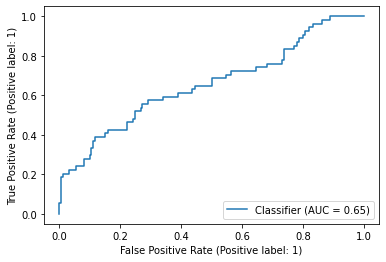

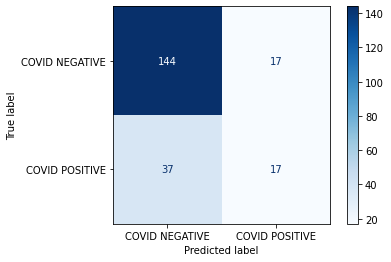

In [36]:
xx = learn.load('./model')

pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)

acc = accuracy_score(actual_classes, pred_classes)
rocauc = roc_auc_score(actual_classes, pred_probas[:, 1], average='macro')
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^    accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))       
RocCurveDisplay.from_predictions(actual_classes, pred_probas[:, 1])
plt.show()

ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab,cmap=plt.cm.Blues)
plt.show()

### ResNet-50

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Better model found at epoch 0 with accuracy value: 0.5958549380302429.


Better model found at epoch 0 with accuracy value: 0.5854922533035278.
Better model found at epoch 1 with accuracy value: 0.6839378476142883.
Better model found at epoch 2 with accuracy value: 0.6943005323410034.
Better model found at epoch 4 with accuracy value: 0.7046632170677185.
Better model found at epoch 9 with accuracy value: 0.7357512712478638.
Better model found at epoch 11 with accuracy value: 0.7461140155792236.
Better model found at epoch 12 with accuracy value: 0.7512953281402588.
Better model found at epoch 13 with accuracy value: 0.772020697593689.
Better model found at epoch 21 with accuracy value: 0.7772020697593689.
No improvement since epoch 21: early stopping


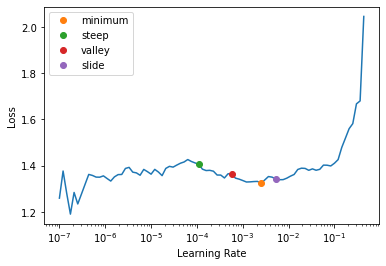

In [37]:
learn = cnn_learner(dls, resnet50, # <- model
                    n_in=1,  # <- This is the only audio specific modification here
                    metrics=[accuracy, RocAucBinary(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True), EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Run 
learn.fine_tune(50, lrs.valley)

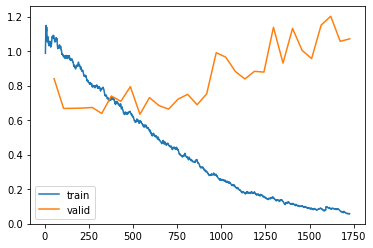

In [38]:
learn.recorder.plot_loss()

0.7627906976744186 0.6961697722567288 0.6387030874163894 0.6262364849321371 0.6262364849321371 0.6742063492063493
^^    accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       161
           1       0.54      0.35      0.43        54

    accuracy                           0.76       215
   macro avg       0.67      0.63      0.64       215
weighted avg       0.74      0.76      0.74       215



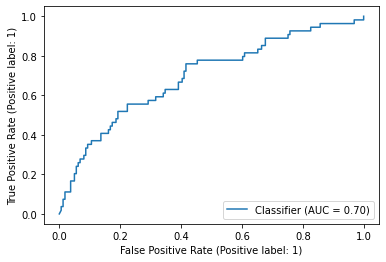

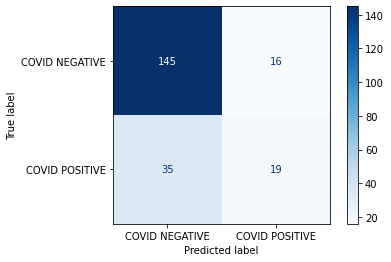

In [39]:
xx = learn.load('./model')

pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)

acc = accuracy_score(actual_classes, pred_classes)
rocauc = roc_auc_score(actual_classes, pred_probas[:, 1], average='macro')
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^    accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))       
RocCurveDisplay.from_predictions(actual_classes, pred_probas[:, 1])
plt.show()

ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab,cmap=plt.cm.Blues)
plt.show()

### ResNet-101

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

Better model found at epoch 0 with accuracy value: 0.5077720284461975.


Better model found at epoch 0 with accuracy value: 0.6165803074836731.
Better model found at epoch 5 with accuracy value: 0.6735751032829285.
Better model found at epoch 10 with accuracy value: 0.6943005323410034.
Better model found at epoch 16 with accuracy value: 0.6994818449020386.
Better model found at epoch 17 with accuracy value: 0.7409326434135437.
Better model found at epoch 19 with accuracy value: 0.7461140155792236.
Better model found at epoch 21 with accuracy value: 0.7668393850326538.
No improvement since epoch 21: early stopping


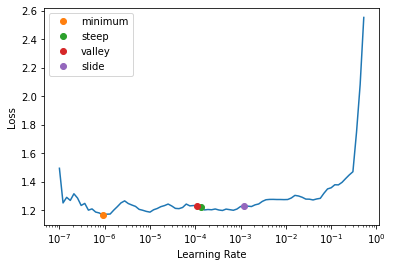

In [40]:
learn = cnn_learner(dls, resnet101, # <- model
                    n_in=1,  # <- This is the only audio specific modification here
                    metrics=[accuracy, RocAucBinary(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True), EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Run 
learn.fine_tune(50, lrs.valley)

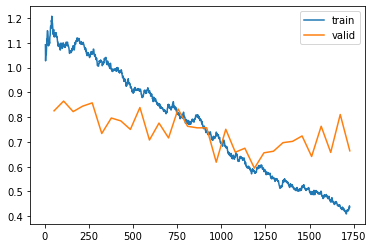

In [41]:
learn.recorder.plot_loss()

0.7116279069767442 0.6892109500805154 0.6299689096158116 0.6351506786289395 0.6351506786289395 0.6263440860215054
^^    accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.82      0.79      0.80       161
           1       0.43      0.48      0.46        54

    accuracy                           0.71       215
   macro avg       0.63      0.64      0.63       215
weighted avg       0.72      0.71      0.72       215



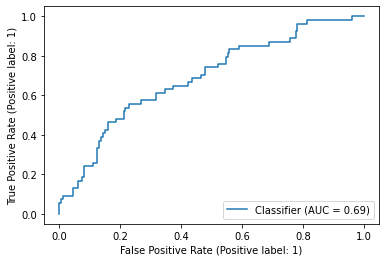

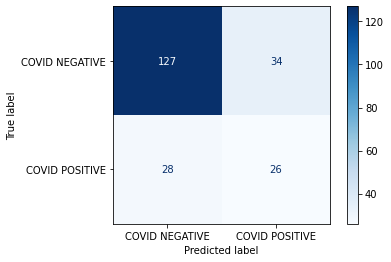

In [42]:
xx = learn.load('./model')

pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)

acc = accuracy_score(actual_classes, pred_classes)
rocauc = roc_auc_score(actual_classes, pred_probas[:, 1], average='macro')
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^    accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))       
RocCurveDisplay.from_predictions(actual_classes, pred_probas[:, 1])
plt.show()

ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab,cmap=plt.cm.Blues)
plt.show()

### vgg16_bn

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Better model found at epoch 0 with accuracy value: 0.6476684212684631.


Better model found at epoch 0 with accuracy value: 0.7564767003059387.
Better model found at epoch 4 with accuracy value: 0.7668393850326538.
No improvement since epoch 4: early stopping


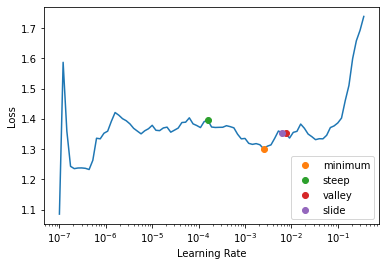

In [43]:
learn = cnn_learner(dls, vgg16_bn, # <- model
                    n_in=1,  # <- This is the only audio specific modification here
                    metrics=[accuracy, RocAucBinary(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True), EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Run 
learn.fine_tune(50, lrs.valley)

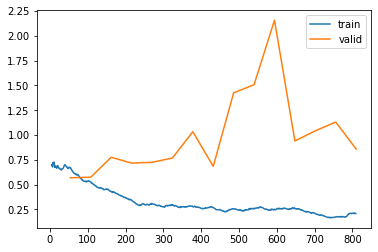

In [44]:
learn.recorder.plot_loss()

0.7348837209302326 0.6353807223372441 0.5820971867007673 0.576834598573729 0.576834598573729 0.6171107994389902
^^    accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.78      0.89      0.83       161
           1       0.45      0.26      0.33        54

    accuracy                           0.73       215
   macro avg       0.62      0.58      0.58       215
weighted avg       0.70      0.73      0.71       215



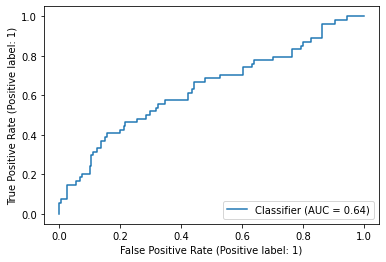

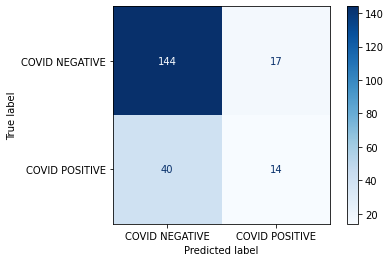

In [45]:
xx = learn.load('./model')

pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)

acc = accuracy_score(actual_classes, pred_classes)
rocauc = roc_auc_score(actual_classes, pred_probas[:, 1], average='macro')
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^    accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))       
RocCurveDisplay.from_predictions(actual_classes, pred_probas[:, 1])
plt.show()

ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab,cmap=plt.cm.Blues)
plt.show()

### vgg19_bn

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

Better model found at epoch 0 with accuracy value: 0.5647668242454529.


Better model found at epoch 0 with accuracy value: 0.5854922533035278.
Better model found at epoch 3 with accuracy value: 0.6269429922103882.
Better model found at epoch 4 with accuracy value: 0.6373056769371033.
Better model found at epoch 5 with accuracy value: 0.6424870491027832.
Better model found at epoch 7 with accuracy value: 0.6580311059951782.
Better model found at epoch 9 with accuracy value: 0.6891191601753235.
Better model found at epoch 11 with accuracy value: 0.7046632170677185.
Better model found at epoch 13 with accuracy value: 0.7150259017944336.
Better model found at epoch 15 with accuracy value: 0.7202072739601135.
Better model found at epoch 17 with accuracy value: 0.7305699586868286.
Better model found at epoch 19 with accuracy value: 0.7668393850326538.
Better model found at epoch 20 with accuracy value: 0.772020697593689.
No improvement since epoch 20: early stopping


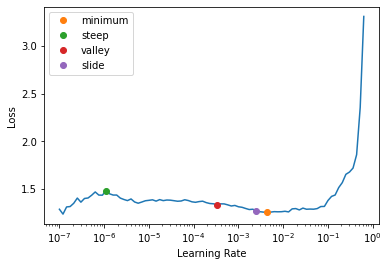

In [46]:
learn = cnn_learner(dls, vgg19_bn, # <- model
                    n_in=1,  # <- This is the only audio specific modification here
                    metrics=[accuracy, RocAucBinary(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True), EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Run 
learn.fine_tune(50, lrs.valley)

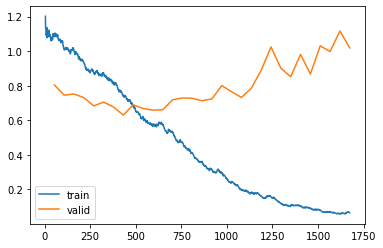

In [47]:
learn.recorder.plot_loss()

0.7255813953488373 0.68944099378882 0.6182551385837671 0.6136991028295377 0.6136991028295377 0.6251899696048633
^^    accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       161
           1       0.45      0.39      0.42        54

    accuracy                           0.73       215
   macro avg       0.63      0.61      0.62       215
weighted avg       0.71      0.73      0.72       215



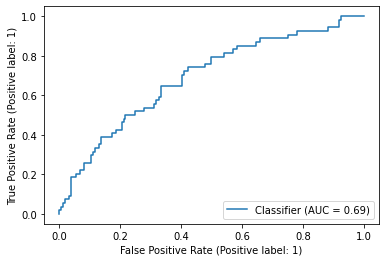

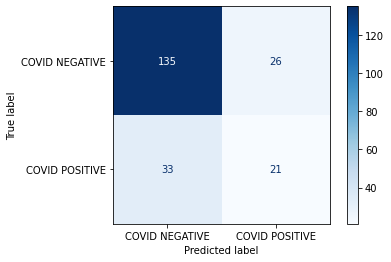

In [48]:
xx = learn.load('./model')

pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)

acc = accuracy_score(actual_classes, pred_classes)
rocauc = roc_auc_score(actual_classes, pred_probas[:, 1], average='macro')
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^    accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))       
RocCurveDisplay.from_predictions(actual_classes, pred_probas[:, 1])
plt.show()

ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab,cmap=plt.cm.Blues)
plt.show()

### alexnet

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Better model found at epoch 0 with accuracy value: 0.6954023241996765.


Better model found at epoch 0 with accuracy value: 0.7241379022598267.
Better model found at epoch 1 with accuracy value: 0.7471264600753784.
Better model found at epoch 3 with accuracy value: 0.7816091775894165.
Better model found at epoch 13 with accuracy value: 0.7873563170433044.
No improvement since epoch 13: early stopping


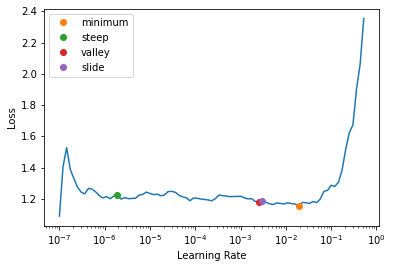

In [100]:
learn = cnn_learner(dls, alexnet, # <- model
                    n_in=1,  # <- This is the only audio specific modification here
                    metrics=[accuracy, RocAucBinary(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True), EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Run 
learn.fine_tune(50, lrs.valley)

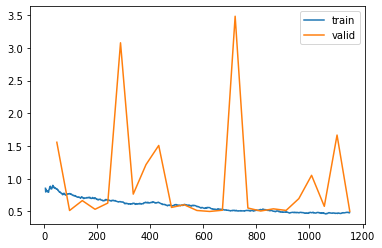

In [101]:
learn.recorder.plot_loss()

0.7461139896373057 0.6810344827586208 0.6239611912998528 0.615014367816092 0.615014367816092 0.644755877034358
^^    accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       145
           1       0.49      0.35      0.41        48

    accuracy                           0.75       193
   macro avg       0.64      0.62      0.62       193
weighted avg       0.72      0.75      0.73       193



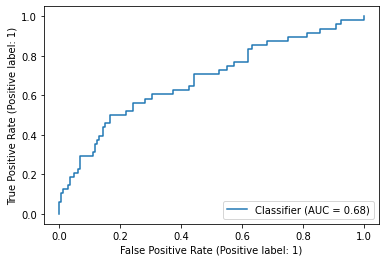

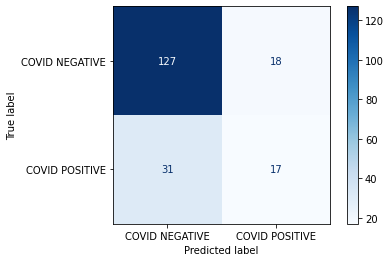

In [102]:
xx = learn.load('./model')

pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)

acc = accuracy_score(actual_classes, pred_classes)
rocauc = roc_auc_score(actual_classes, pred_probas[:, 1], average='macro')
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^    accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))       
RocCurveDisplay.from_predictions(actual_classes, pred_probas[:, 1])
plt.show()

ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab,cmap=plt.cm.Blues)
plt.show()

### squeezenet1_0

Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth


  0%|          | 0.00/4.78M [00:00<?, ?B/s]

Better model found at epoch 0 with accuracy value: 0.7512953281402588.


Better model found at epoch 0 with accuracy value: 0.7046632170677185.
Better model found at epoch 1 with accuracy value: 0.7253885865211487.
Better model found at epoch 3 with accuracy value: 0.7668393850326538.
Better model found at epoch 5 with accuracy value: 0.7772020697593689.
Better model found at epoch 13 with accuracy value: 0.7823834419250488.
Better model found at epoch 18 with accuracy value: 0.7979274392127991.
No improvement since epoch 18: early stopping


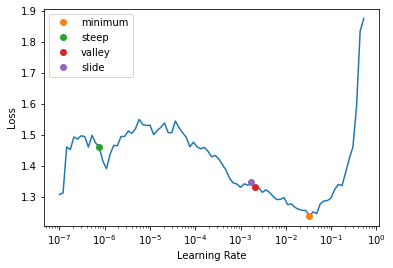

In [52]:
learn = cnn_learner(dls, squeezenet1_0, # <- model
                    n_in=1,  # <- This is the only audio specific modification here
                    metrics=[accuracy, RocAucBinary(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True), EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Run 
learn.fine_tune(50, lrs.valley)

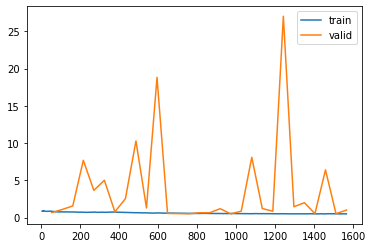

In [53]:
learn.recorder.plot_loss()

0.7953488372093023 0.7244076374511157 0.655448717948718 0.6356682769726248 0.6356682769726248 0.7573080279232112
^^    accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.81      0.96      0.88       161
           1       0.71      0.31      0.44        54

    accuracy                           0.80       215
   macro avg       0.76      0.64      0.66       215
weighted avg       0.78      0.80      0.76       215



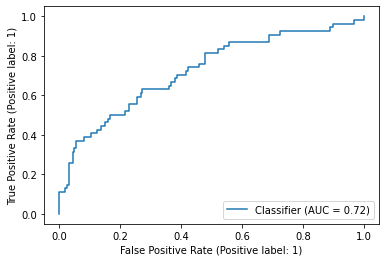

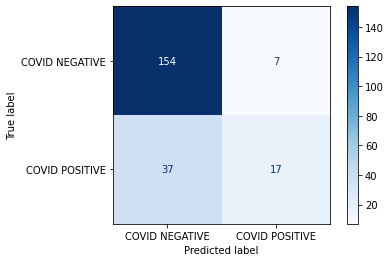

In [54]:
xx = learn.load('./model')

pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)

acc = accuracy_score(actual_classes, pred_classes)
rocauc = roc_auc_score(actual_classes, pred_probas[:, 1], average='macro')
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^    accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))       
RocCurveDisplay.from_predictions(actual_classes, pred_probas[:, 1])
plt.show()

ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab,cmap=plt.cm.Blues)
plt.show()

### densenet121

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

Better model found at epoch 0 with accuracy value: 0.5440414547920227.


Better model found at epoch 0 with accuracy value: 0.5854922533035278.
Better model found at epoch 1 with accuracy value: 0.6891191601753235.
Better model found at epoch 5 with accuracy value: 0.7098445892333984.
Better model found at epoch 6 with accuracy value: 0.7150259017944336.
Better model found at epoch 12 with accuracy value: 0.7357512712478638.
Better model found at epoch 16 with accuracy value: 0.7616580128669739.
Better model found at epoch 26 with accuracy value: 0.7772020697593689.
No improvement since epoch 26: early stopping


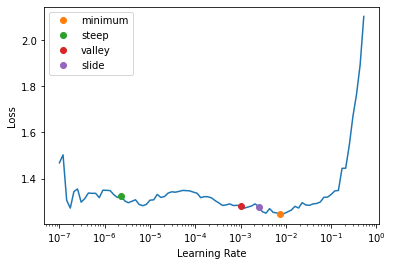

In [55]:
learn = cnn_learner(dls, densenet121, # <- model
                    n_in=1,  # <- This is the only audio specific modification here
                    metrics=[accuracy, RocAucBinary(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True), EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Run 
learn.fine_tune(50, lrs.valley)

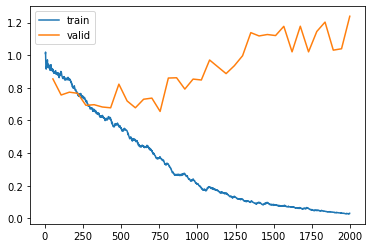

In [56]:
learn.recorder.plot_loss()

0.7581395348837209 0.7516678168852082 0.6346405228758171 0.6231308948700254 0.6231308948700254 0.6661235257603972
^^    accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.80      0.89      0.85       161
           1       0.53      0.35      0.42        54

    accuracy                           0.76       215
   macro avg       0.67      0.62      0.63       215
weighted avg       0.73      0.76      0.74       215



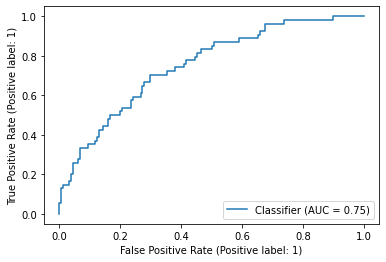

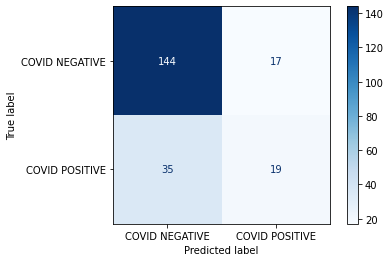

In [57]:
xx = learn.load('./model')

pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)

acc = accuracy_score(actual_classes, pred_classes)
rocauc = roc_auc_score(actual_classes, pred_probas[:, 1], average='macro')
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^    accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))       
RocCurveDisplay.from_predictions(actual_classes, pred_probas[:, 1])
plt.show()

ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab,cmap=plt.cm.Blues)
plt.show()

### xresnet50

Downloading: "https://s3.amazonaws.com/fast-ai-modelzoo/xrn50_940.pth" to /root/.cache/torch/hub/checkpoints/xrn50_940.pth


  0%|          | 0.00/244M [00:00<?, ?B/s]

Better model found at epoch 0 with accuracy value: 0.6943005323410034.


Better model found at epoch 0 with accuracy value: 0.7927461266517639.
Better model found at epoch 7 with accuracy value: 0.7979274392127991.
Better model found at epoch 17 with accuracy value: 0.803108811378479.
No improvement since epoch 17: early stopping


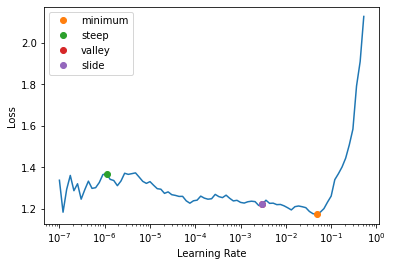

In [58]:
learn = cnn_learner(dls, xresnet50, # <- model
                    n_in=1,  # <- This is the only audio specific modification here
                    metrics=[accuracy, RocAucBinary(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True), EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Run 
learn.fine_tune(50, lrs.valley)

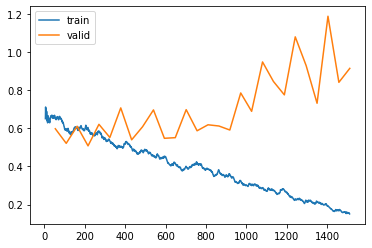

In [59]:
learn.recorder.plot_loss()

0.7627906976744186 0.7306188175753393 0.6387030874163894 0.6262364849321371 0.6262364849321371 0.6742063492063493
^^    accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       161
           1       0.54      0.35      0.43        54

    accuracy                           0.76       215
   macro avg       0.67      0.63      0.64       215
weighted avg       0.74      0.76      0.74       215



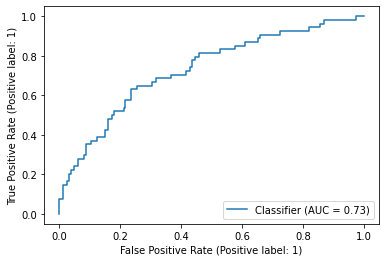

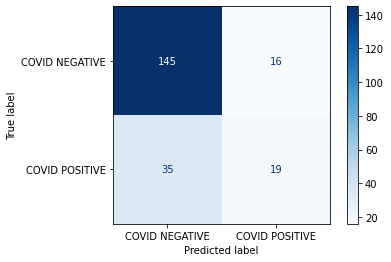

In [60]:
xx = learn.load('./model')

pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)

acc = accuracy_score(actual_classes, pred_classes)
rocauc = roc_auc_score(actual_classes, pred_probas[:, 1], average='macro')
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^    accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))       
RocCurveDisplay.from_predictions(actual_classes, pred_probas[:, 1])
plt.show()

ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab,cmap=plt.cm.Blues)
plt.show()

# Models: 1cycle policy

### ResNet-18

Better model found at epoch 0 with accuracy value: 0.5544041395187378.
Better model found at epoch 1 with accuracy value: 0.6476684212684631.
Better model found at epoch 3 with accuracy value: 0.6632124185562134.
Better model found at epoch 4 with accuracy value: 0.6735751032829285.
Better model found at epoch 5 with accuracy value: 0.772020697593689.
No improvement since epoch 5: early stopping


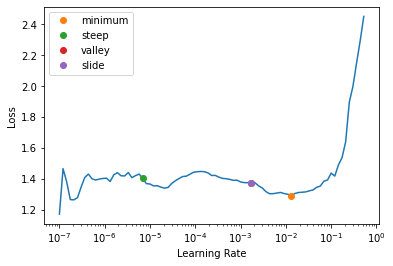

In [61]:
learn = cnn_learner(dls, resnet18, # <- model
                    n_in=1,  # <- This is the only audio specific modification here
                    metrics=[accuracy, RocAucBinary(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True), EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Run 
learn.fit_one_cycle(50, lrs.valley)

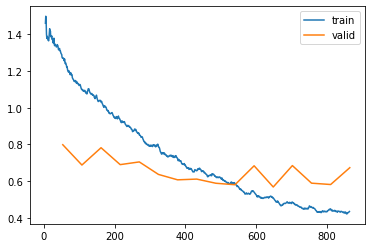

In [62]:
learn.recorder.plot_loss()

0.6790697674418604 0.6024844720496895 0.570758947947108 0.5703358638141247 0.5703358638141247 0.5712205916608433
^^    accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.78      0.79      0.79       161
           1       0.36      0.35      0.36        54

    accuracy                           0.68       215
   macro avg       0.57      0.57      0.57       215
weighted avg       0.68      0.68      0.68       215



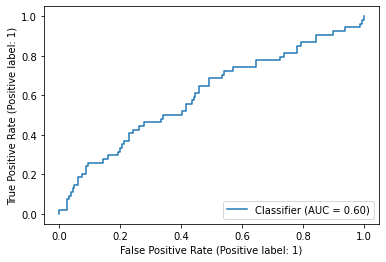

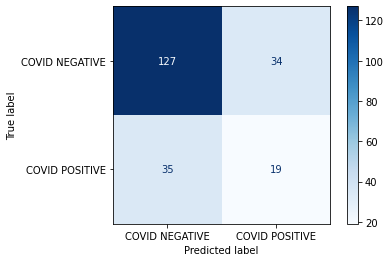

In [63]:
xx = learn.load('./model')

pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)

acc = accuracy_score(actual_classes, pred_classes)
rocauc = roc_auc_score(actual_classes, pred_probas[:, 1], average='macro')
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^    accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))       
RocCurveDisplay.from_predictions(actual_classes, pred_probas[:, 1])
plt.show()

ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab,cmap=plt.cm.Blues)
plt.show()

### ResNet-34

Better model found at epoch 0 with accuracy value: 0.5854922533035278.
Better model found at epoch 1 with accuracy value: 0.6269429922103882.
Better model found at epoch 3 with accuracy value: 0.6839378476142883.
Better model found at epoch 4 with accuracy value: 0.7305699586868286.
Better model found at epoch 7 with accuracy value: 0.7512953281402588.
Better model found at epoch 11 with accuracy value: 0.7564767003059387.
Better model found at epoch 13 with accuracy value: 0.772020697593689.
No improvement since epoch 13: early stopping


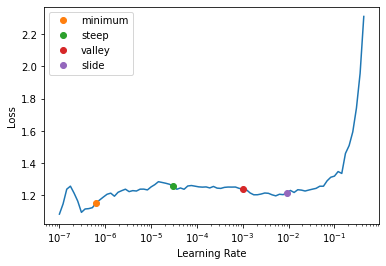

In [64]:
learn = cnn_learner(dls, resnet34, # <- model
                    n_in=1,  # <- This is the only audio specific modification here
                    metrics=[accuracy, RocAucBinary(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True), EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Run 
learn.fit_one_cycle(50, lrs.valley)

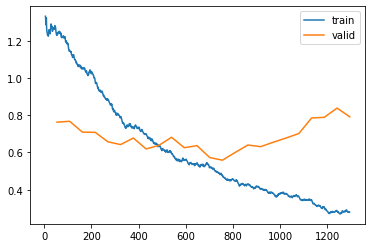

In [65]:
learn.recorder.plot_loss()

0.7116279069767442 0.6436622958362087 0.5713275019295085 0.5674603174603174 0.5674603174603174 0.5871989295272079
^^    accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.78      0.86      0.82       161
           1       0.39      0.28      0.33        54

    accuracy                           0.71       215
   macro avg       0.59      0.57      0.57       215
weighted avg       0.68      0.71      0.69       215



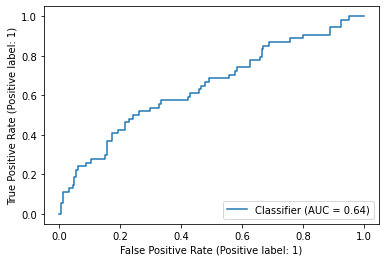

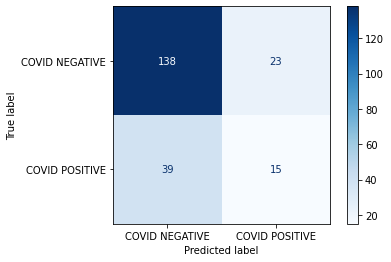

In [66]:
xx = learn.load('./model')

pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)

acc = accuracy_score(actual_classes, pred_classes)
rocauc = roc_auc_score(actual_classes, pred_probas[:, 1], average='macro')
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^    accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))       
RocCurveDisplay.from_predictions(actual_classes, pred_probas[:, 1])
plt.show()

ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab,cmap=plt.cm.Blues)
plt.show()

### ResNet-50

Better model found at epoch 0 with accuracy value: 0.46113988757133484.
Better model found at epoch 1 with accuracy value: 0.48704662919044495.
Better model found at epoch 2 with accuracy value: 0.5181347131729126.
Better model found at epoch 3 with accuracy value: 0.590673565864563.
Better model found at epoch 6 with accuracy value: 0.621761679649353.
Better model found at epoch 7 with accuracy value: 0.6269429922103882.
Better model found at epoch 8 with accuracy value: 0.7150259017944336.
Better model found at epoch 11 with accuracy value: 0.7461140155792236.
Better model found at epoch 13 with accuracy value: 0.772020697593689.
Better model found at epoch 22 with accuracy value: 0.7823834419250488.
Better model found at epoch 32 with accuracy value: 0.7927461266517639.
No improvement since epoch 32: early stopping


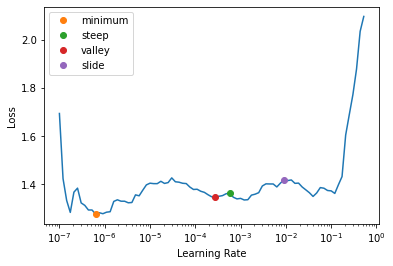

In [67]:
learn = cnn_learner(dls, resnet50, # <- model
                    n_in=1,  # <- This is the only audio specific modification here
                    metrics=[accuracy, RocAucBinary(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True), EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Run 
learn.fit_one_cycle(50, lrs.valley)

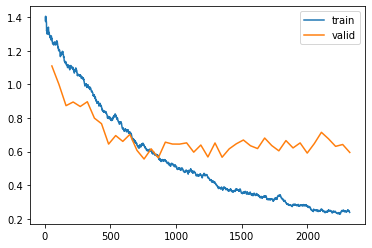

In [68]:
learn.recorder.plot_loss()

0.7395348837209302 0.6710374971244537 0.6537842190016103 0.6537842190016103 0.6537842190016103 0.6537842190016103
^^    accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       161
           1       0.48      0.48      0.48        54

    accuracy                           0.74       215
   macro avg       0.65      0.65      0.65       215
weighted avg       0.74      0.74      0.74       215



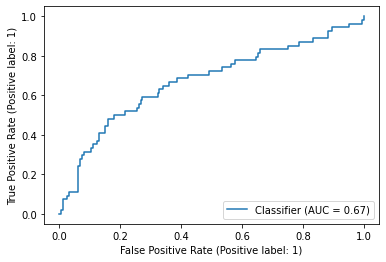

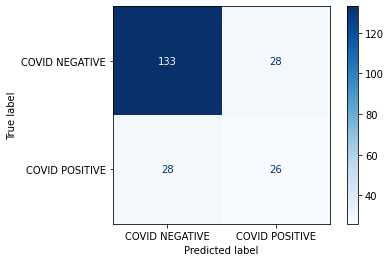

In [69]:
xx = learn.load('./model')

pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)

acc = accuracy_score(actual_classes, pred_classes)
rocauc = roc_auc_score(actual_classes, pred_probas[:, 1], average='macro')
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^    accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))       
RocCurveDisplay.from_predictions(actual_classes, pred_probas[:, 1])
plt.show()

ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab,cmap=plt.cm.Blues)
plt.show()

### ResNet-101

Better model found at epoch 0 with accuracy value: 0.6373056769371033.
Better model found at epoch 2 with accuracy value: 0.6632124185562134.
Better model found at epoch 3 with accuracy value: 0.6735751032829285.
Better model found at epoch 6 with accuracy value: 0.772020697593689.
No improvement since epoch 6: early stopping


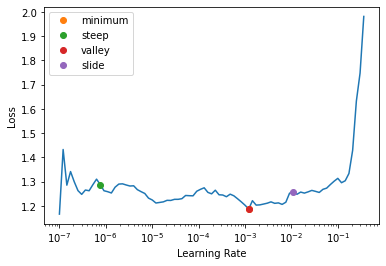

In [70]:
learn = cnn_learner(dls, resnet101, # <- model
                    n_in=1,  # <- This is the only audio specific modification here
                    metrics=[accuracy, RocAucBinary(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True), EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Run 
learn.fit_one_cycle(50, lrs.valley)

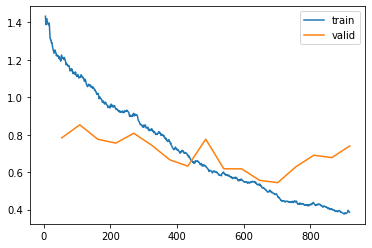

In [71]:
learn.recorder.plot_loss()

0.6976744186046512 0.6197377501725327 0.5608798114689709 0.5581435472739821 0.5581435472739821 0.5708578637510513
^^    accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.78      0.84      0.81       161
           1       0.37      0.28      0.32        54

    accuracy                           0.70       215
   macro avg       0.57      0.56      0.56       215
weighted avg       0.67      0.70      0.68       215



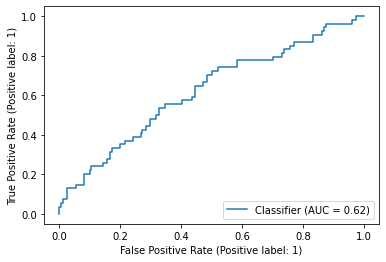

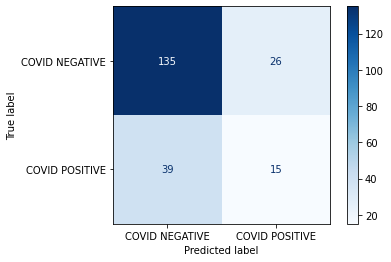

In [72]:
xx = learn.load('./model')

pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)

acc = accuracy_score(actual_classes, pred_classes)
rocauc = roc_auc_score(actual_classes, pred_probas[:, 1], average='macro')
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^    accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))       
RocCurveDisplay.from_predictions(actual_classes, pred_probas[:, 1])
plt.show()

ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab,cmap=plt.cm.Blues)
plt.show()

### vgg16_bn

Better model found at epoch 0 with accuracy value: 0.6632124185562134.
Better model found at epoch 1 with accuracy value: 0.6839378476142883.
Better model found at epoch 2 with accuracy value: 0.6943005323410034.
Better model found at epoch 3 with accuracy value: 0.7357512712478638.
Better model found at epoch 6 with accuracy value: 0.7461140155792236.
Better model found at epoch 9 with accuracy value: 0.7668393850326538.
Better model found at epoch 12 with accuracy value: 0.772020697593689.
Better model found at epoch 13 with accuracy value: 0.787564754486084.
No improvement since epoch 13: early stopping


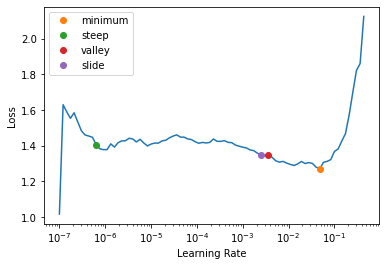

In [73]:
learn = cnn_learner(dls, vgg16_bn, # <- model
                    n_in=1,  # <- This is the only audio specific modification here
                    metrics=[accuracy, RocAucBinary(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True), EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Run 
learn.fit_one_cycle(50, lrs.valley)

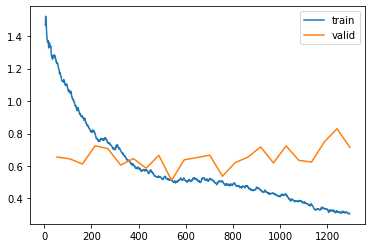

In [74]:
learn.recorder.plot_loss()

0.7813953488372093 0.6387163561076604 0.6035544744791871 0.5955831608005522 0.5955831608005522 0.7468805704099821
^^    accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.79      0.97      0.87       161
           1       0.71      0.22      0.34        54

    accuracy                           0.78       215
   macro avg       0.75      0.60      0.60       215
weighted avg       0.77      0.78      0.74       215



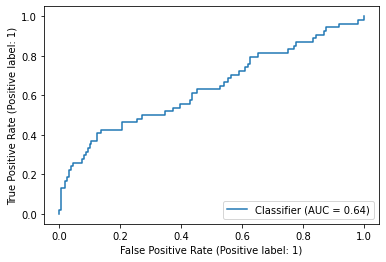

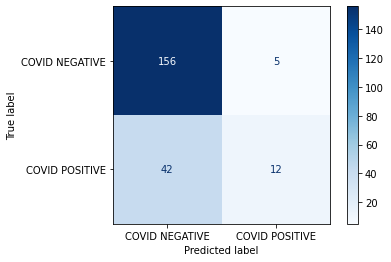

In [75]:
xx = learn.load('./model')

pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)

acc = accuracy_score(actual_classes, pred_classes)
rocauc = roc_auc_score(actual_classes, pred_probas[:, 1], average='macro')
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^    accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))       
RocCurveDisplay.from_predictions(actual_classes, pred_probas[:, 1])
plt.show()

ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab,cmap=plt.cm.Blues)
plt.show()

### vgg19_bn

Better model found at epoch 0 with accuracy value: 0.5233160853385925.
Better model found at epoch 1 with accuracy value: 0.5803108811378479.
Better model found at epoch 2 with accuracy value: 0.606217622756958.
Better model found at epoch 3 with accuracy value: 0.6683937907218933.
Better model found at epoch 4 with accuracy value: 0.7046632170677185.
Better model found at epoch 5 with accuracy value: 0.7202072739601135.
Better model found at epoch 7 with accuracy value: 0.7305699586868286.
Better model found at epoch 10 with accuracy value: 0.7823834419250488.
No improvement since epoch 10: early stopping


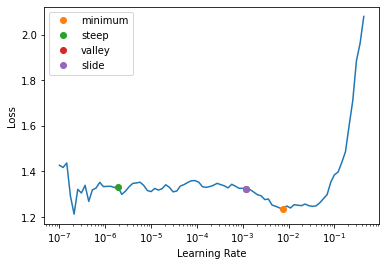

In [76]:
learn = cnn_learner(dls, vgg19_bn, # <- model
                    n_in=1,  # <- This is the only audio specific modification here
                    metrics=[accuracy, RocAucBinary(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True), EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Run 
learn.fit_one_cycle(50, lrs.valley)

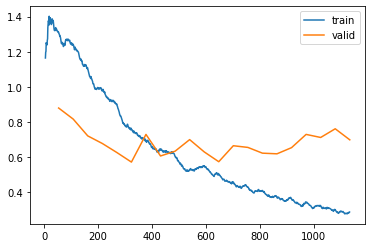

In [77]:
learn.recorder.plot_loss()

0.7488372093023256 0.5752242926155969 0.6005367464905037 0.5923050379572119 0.5923050379572119 0.6445945945945946
^^    accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.79      0.91      0.84       161
           1       0.50      0.28      0.36        54

    accuracy                           0.75       215
   macro avg       0.64      0.59      0.60       215
weighted avg       0.72      0.75      0.72       215



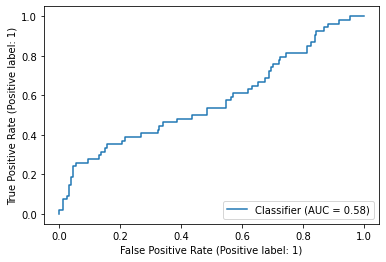

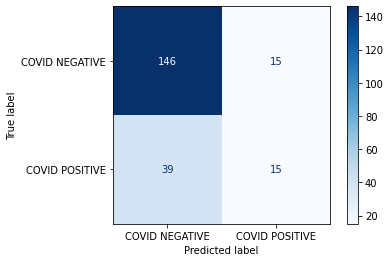

In [78]:
xx = learn.load('./model')

pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)

acc = accuracy_score(actual_classes, pred_classes)
rocauc = roc_auc_score(actual_classes, pred_probas[:, 1], average='macro')
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^    accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))       
RocCurveDisplay.from_predictions(actual_classes, pred_probas[:, 1])
plt.show()

ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab,cmap=plt.cm.Blues)
plt.show()

### alexnet

Better model found at epoch 0 with accuracy value: 0.5977011322975159.
Better model found at epoch 1 with accuracy value: 0.6321839094161987.
Better model found at epoch 2 with accuracy value: 0.6724137663841248.
Better model found at epoch 3 with accuracy value: 0.6954023241996765.
Better model found at epoch 4 with accuracy value: 0.7701149582862854.
No improvement since epoch 4: early stopping


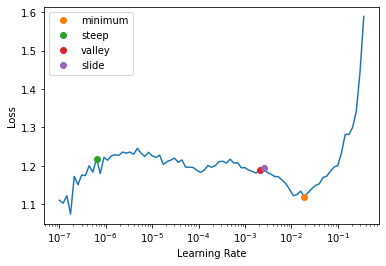

In [103]:
learn = cnn_learner(dls, alexnet, # <- model
                    n_in=1,  # <- This is the only audio specific modification here
                    metrics=[accuracy, RocAucBinary(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True), EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Run 
learn.fit_one_cycle(50, lrs.valley)

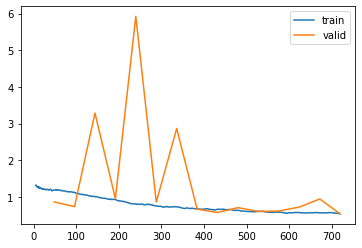

In [104]:
learn.recorder.plot_loss()

0.7461139896373057 0.6293103448275861 0.586108801260449 0.5801724137931035 0.5801724137931035 0.6328571428571428
^^    accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.79      0.91      0.84       145
           1       0.48      0.25      0.33        48

    accuracy                           0.75       193
   macro avg       0.63      0.58      0.59       193
weighted avg       0.71      0.75      0.72       193



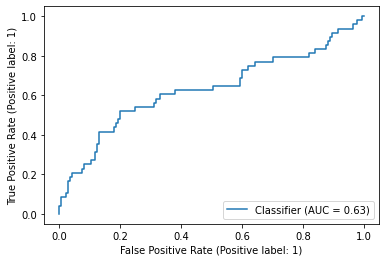

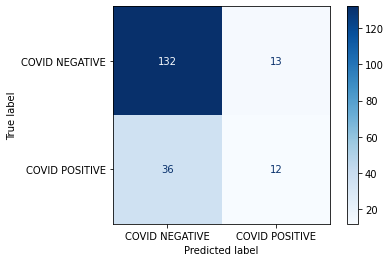

In [105]:
xx = learn.load('./model')

pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)

acc = accuracy_score(actual_classes, pred_classes)
rocauc = roc_auc_score(actual_classes, pred_probas[:, 1], average='macro')
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^    accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))       
RocCurveDisplay.from_predictions(actual_classes, pred_probas[:, 1])
plt.show()

ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab,cmap=plt.cm.Blues)
plt.show()

### squeezenet1_0

Better model found at epoch 0 with accuracy value: 0.575129508972168.
Better model found at epoch 1 with accuracy value: 0.6113989353179932.
Better model found at epoch 2 with accuracy value: 0.6994818449020386.
Better model found at epoch 4 with accuracy value: 0.7409326434135437.
Better model found at epoch 5 with accuracy value: 0.7512953281402588.
Better model found at epoch 7 with accuracy value: 0.7616580128669739.
Better model found at epoch 10 with accuracy value: 0.787564754486084.
Better model found at epoch 13 with accuracy value: 0.818652868270874.
No improvement since epoch 13: early stopping


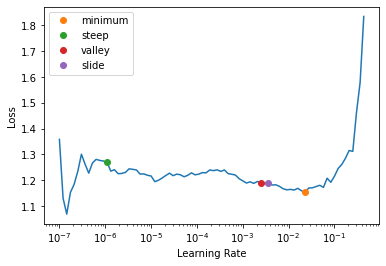

In [82]:
learn = cnn_learner(dls, squeezenet1_0, # <- model
                    n_in=1,  # <- This is the only audio specific modification here
                    metrics=[accuracy, RocAucBinary(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True), EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Run 
learn.fit_one_cycle(50, lrs.valley)

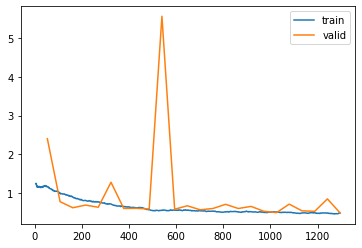

In [83]:
learn.recorder.plot_loss()

0.7581395348837209 0.6919714745801704 0.6346405228758171 0.6231308948700254 0.6231308948700254 0.6661235257603972
^^    accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.80      0.89      0.85       161
           1       0.53      0.35      0.42        54

    accuracy                           0.76       215
   macro avg       0.67      0.62      0.63       215
weighted avg       0.73      0.76      0.74       215



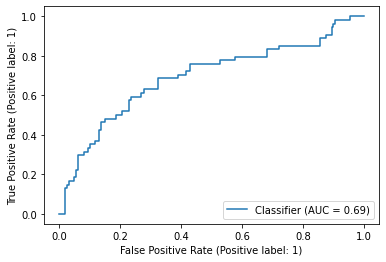

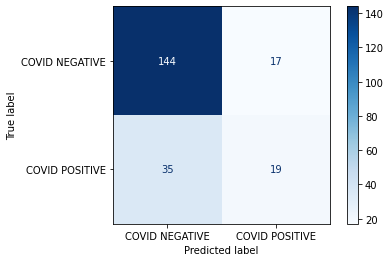

In [84]:
xx = learn.load('./model')

pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)

acc = accuracy_score(actual_classes, pred_classes)
rocauc = roc_auc_score(actual_classes, pred_probas[:, 1], average='macro')
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^    accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))       
RocCurveDisplay.from_predictions(actual_classes, pred_probas[:, 1])
plt.show()

ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab,cmap=plt.cm.Blues)
plt.show()

### densenet121

Better model found at epoch 0 with accuracy value: 0.48704662919044495.
Better model found at epoch 1 with accuracy value: 0.4922279715538025.
Better model found at epoch 2 with accuracy value: 0.590673565864563.
Better model found at epoch 3 with accuracy value: 0.6010362505912781.
Better model found at epoch 4 with accuracy value: 0.606217622756958.
Better model found at epoch 5 with accuracy value: 0.6839378476142883.
Better model found at epoch 8 with accuracy value: 0.7098445892333984.
Better model found at epoch 9 with accuracy value: 0.7253885865211487.
Better model found at epoch 14 with accuracy value: 0.772020697593689.
No improvement since epoch 14: early stopping


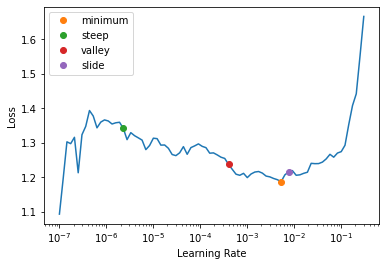

In [85]:
learn = cnn_learner(dls, densenet121, # <- model
                    n_in=1,  # <- This is the only audio specific modification here
                    metrics=[accuracy, RocAucBinary(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True), EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Run 
learn.fit_one_cycle(50, lrs.valley)

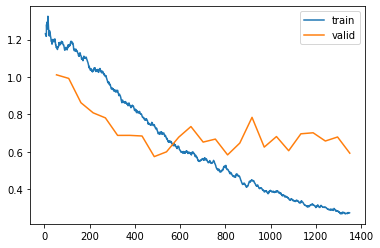

In [86]:
learn.recorder.plot_loss()

0.7348837209302326 0.6533241315850011 0.5961975682889057 0.589141936968024 0.589141936968024 0.623015873015873
^^    accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.79      0.88      0.83       161
           1       0.46      0.30      0.36        54

    accuracy                           0.73       215
   macro avg       0.62      0.59      0.60       215
weighted avg       0.71      0.73      0.71       215



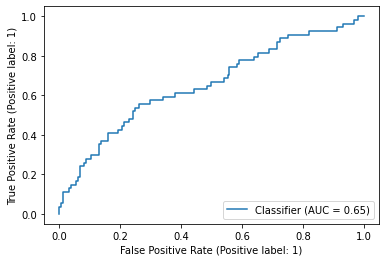

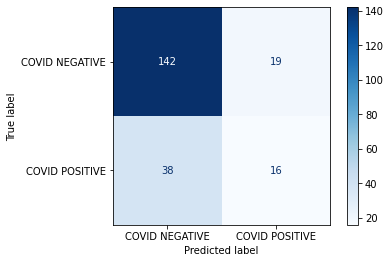

In [87]:
xx = learn.load('./model')

pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)

acc = accuracy_score(actual_classes, pred_classes)
rocauc = roc_auc_score(actual_classes, pred_probas[:, 1], average='macro')
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^    accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))       
RocCurveDisplay.from_predictions(actual_classes, pred_probas[:, 1])
plt.show()

ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab,cmap=plt.cm.Blues)
plt.show()

### xresnet50

Better model found at epoch 0 with accuracy value: 0.7046632170677185.
Better model found at epoch 1 with accuracy value: 0.7150259017944336.
Better model found at epoch 3 with accuracy value: 0.7564767003059387.
Better model found at epoch 4 with accuracy value: 0.772020697593689.
Better model found at epoch 7 with accuracy value: 0.7772020697593689.
Better model found at epoch 8 with accuracy value: 0.7823834419250488.
Better model found at epoch 13 with accuracy value: 0.803108811378479.
Better model found at epoch 15 with accuracy value: 0.8238341808319092.
No improvement since epoch 15: early stopping


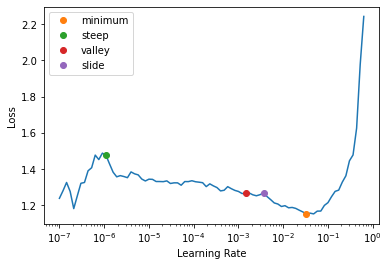

In [88]:
learn = cnn_learner(dls, xresnet50, # <- model
                    n_in=1,  # <- This is the only audio specific modification here
                    metrics=[accuracy, RocAucBinary(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True), EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Run 
learn.fit_one_cycle(50, lrs.valley)

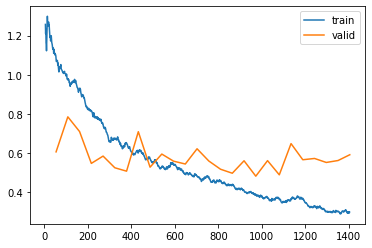

In [89]:
learn.recorder.plot_loss()

0.8 0.6935817805383022 0.7003144348277092 0.6818495514147688 0.6818495514147688 0.740054661402976
^^    accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.83      0.92      0.87       161
           1       0.65      0.44      0.53        54

    accuracy                           0.80       215
   macro avg       0.74      0.68      0.70       215
weighted avg       0.79      0.80      0.79       215



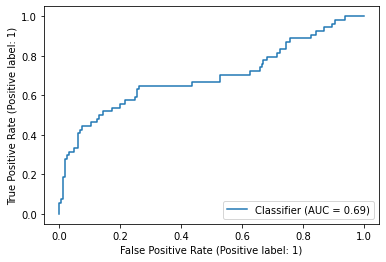

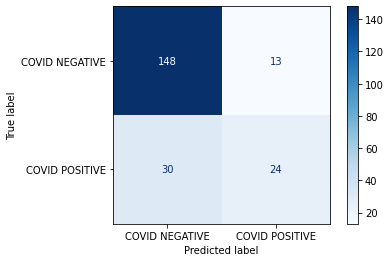

In [90]:
xx = learn.load('./model')

pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)

acc = accuracy_score(actual_classes, pred_classes)
rocauc = roc_auc_score(actual_classes, pred_probas[:, 1], average='macro')
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^    accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))       
RocCurveDisplay.from_predictions(actual_classes, pred_probas[:, 1])
plt.show()

ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab,cmap=plt.cm.Blues)
plt.show()